In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pickle
import re
import time

import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np

import tensorflow as tf
print("TensorFlow version: {}".format(tf.VERSION))

import tflearn

# flare-ai imports
from utils import featurize_utils, plot_utils

TensorFlow version: 1.12.0
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


# Load Data

Data generation is now exported to `featurize_gamestate.py`

In [3]:
game_state_dir = '/Users/leopekelis/flare/flare-ai/data/'
os.listdir(game_state_dir)

['game_states_features_20180611_002848.h5',
 'game_states_features_20180804_132357.h5',
 'game_states_20180819_203145.p',
 'game_states_features_20180819_203145.h5',
 'game_states_features_20180804_134843.h5',
 'game_states_20180804_132357.p',
 'game_states_20180804_125959.p',
 'game_states_20180804_134843.p',
 'game_states_features_20180804_125959.h5',
 'game_states_features_20180804_125020.h5',
 'game_states_20180804_125020.p',
 'game_states_20180611_002848.p',
 'game_states_features_20180611_001434.h5']

In [4]:
game_state_store = pd.HDFStore(game_state_dir + 'game_states_features_20180804_134843.h5')
print(game_state_store)
X = game_state_store.get('X')
y = game_state_store.get('y')
y_entity_damage = game_state_store.get('y_entity_damage')


<class 'pandas.io.pytables.HDFStore'>
File path: /Users/leopekelis/flare/flare-ai/data/game_states_features_20180804_134843.h5



In [5]:
with open(game_state_dir + 'game_states_20180804_134843.p', 'rb') as f:
    game_states = pickle.load(f)

# Diagnostics

In [7]:
collision_layer = featurize_utils.load_collision_layer()

/Users/leopekelis/flare/flare-ai/utils/plot_utils.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  }, names=['who']


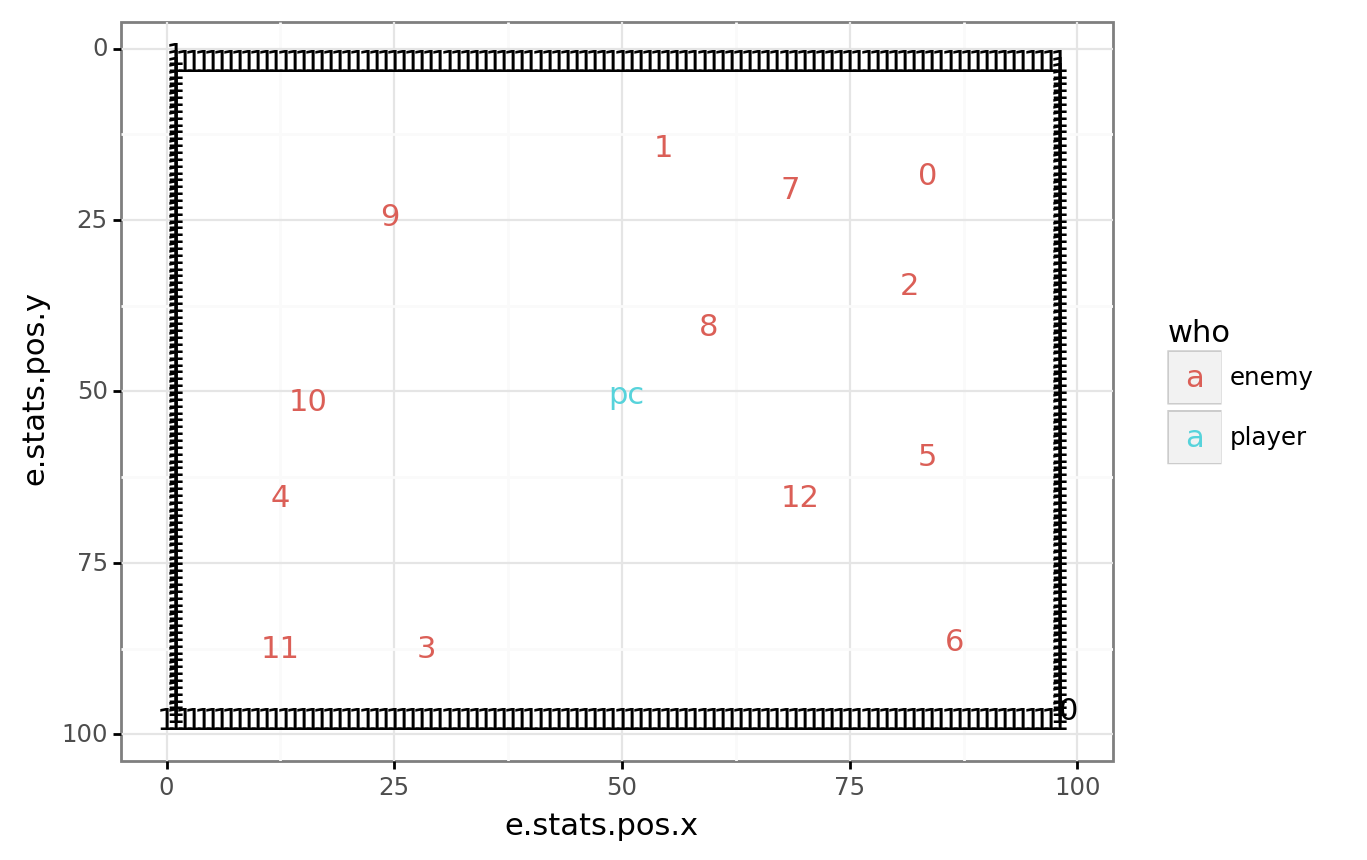

<ggplot: (7621241499)>

In [9]:
plot_utils.plot_state(game_states[0], [collision_layer], ['black'])

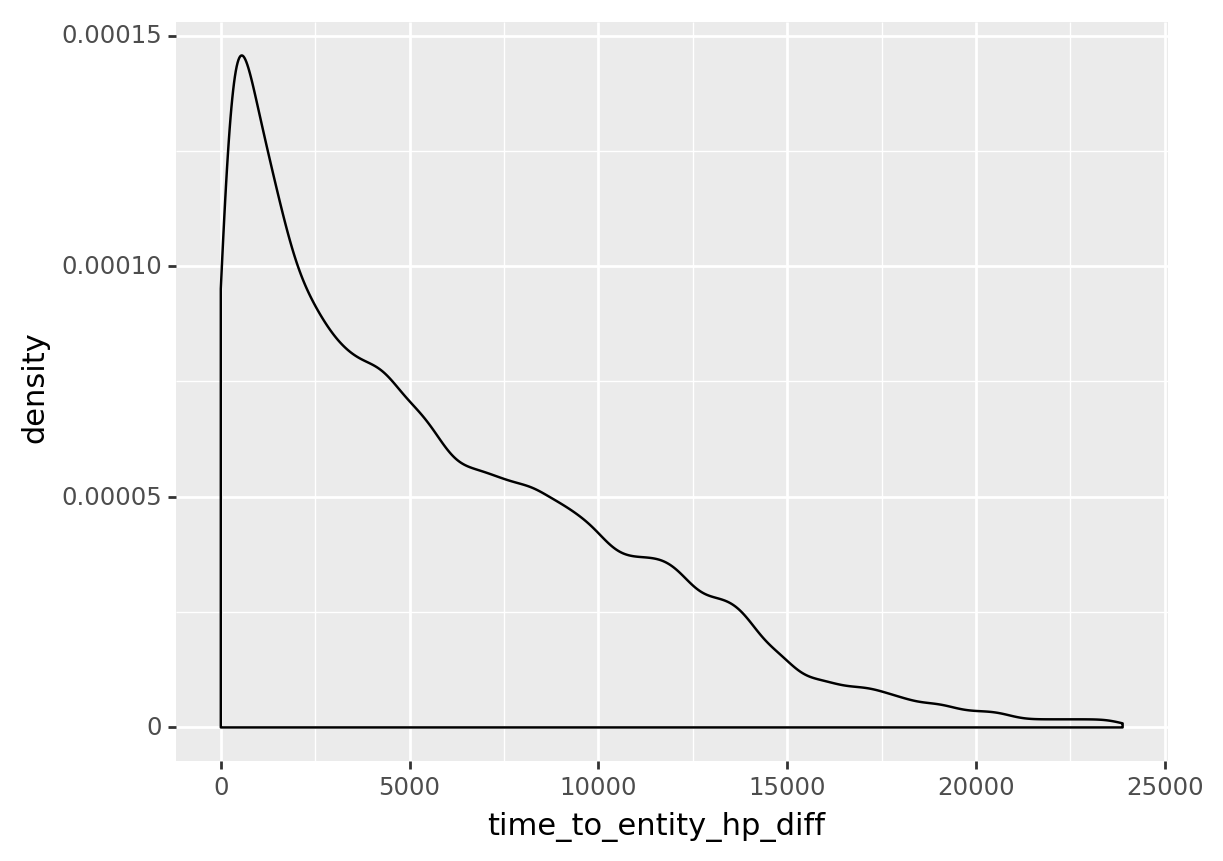

<ggplot: (7619571001)>

In [10]:
(
    ggplot(y, aes(x='time_to_entity_hp_diff')) 
    + geom_density()
)

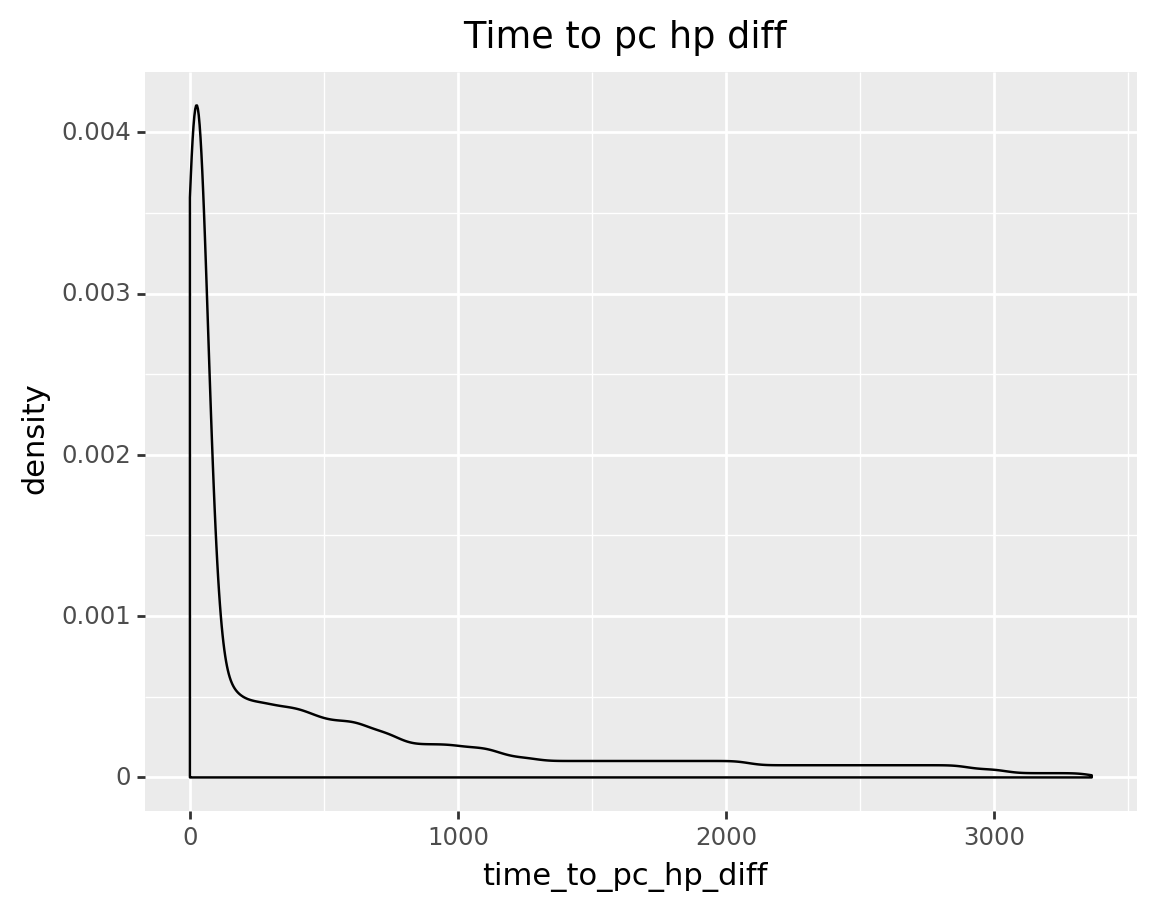

<ggplot: (-9223372029235201269)>

In [11]:
(
    ggplot(y, aes(x='time_to_pc_hp_diff')) 
    + geom_density()
    + ggtitle('Time to pc hp diff')
)

# Load model

In [12]:
# Build neural network
net = tflearn.input_data(shape=[None, 108])
net = tflearn.fully_connected(net, 64, activation='relu')
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 32, activation='relu')
net = tflearn.fully_connected(net, 16, activation='relu')
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net)

# Define model
model = tflearn.DNN(net)

MODEL_DIR = '/Users/leopekelis/flare/flare-ai/models/'
MODEL_NAME = 'median_time_to_damage_20180805_094041'
model.load(MODEL_DIR + MODEL_NAME + '.tflearn')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from /Users/leopekelis/flare/flare-ai/models/median_time_to_damage_20180805_094041.tflearn


# Predict

In [13]:
pred = pd.DataFrame(
    model.predict(
        np.array(X, dtype=np.float32)
    )
)

In [14]:
pred.describe()

,0,1
count,568930.000000,5.689300e+05
mean,0.507511,4.924893e-01
std,0.370034,3.700339e-01
min,0.000000,2.390356e-27
25%,0.133311,1.245864e-01
50%,0.507695,4.923046e-01
75%,0.875414,8.666891e-01
max,1.000000,1.000000e+00


In [16]:
least_safe_idxs = pred.sort_values(0).head().index.values
safest_idxs = pred.sort_values(0,ascending=False).head().index.values

## Least Safe Positions

e.stats.hp       50.000000
e.stats.mp        0.000000
e.stats.pos.x    28.471687
e.stats.pos.y    45.515106
pc.stats.hp      84.000000
pc.stats.mp      12.000000
e.pc.dx           8.759739
e.pc.dy          -5.004341
Name: (13788, 1), dtype: float64

is_entity_alive                        1.0
entity_hp                             50.0
pc_hp                                 84.0
entity_hp_diff                         0.0
pc_hp_diff                             0.0
time_to_entity_hp_diff              2176.0
time_above_median_entity_hp_diff       0.0
time_to_pc_hp_diff                    35.0
time_above_median_pc_hp_diff           0.0
Name: (13788, 1), dtype: float64

/Users/leopekelis/flare/flare-ai/utils/plot_utils.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  }, names=['who']


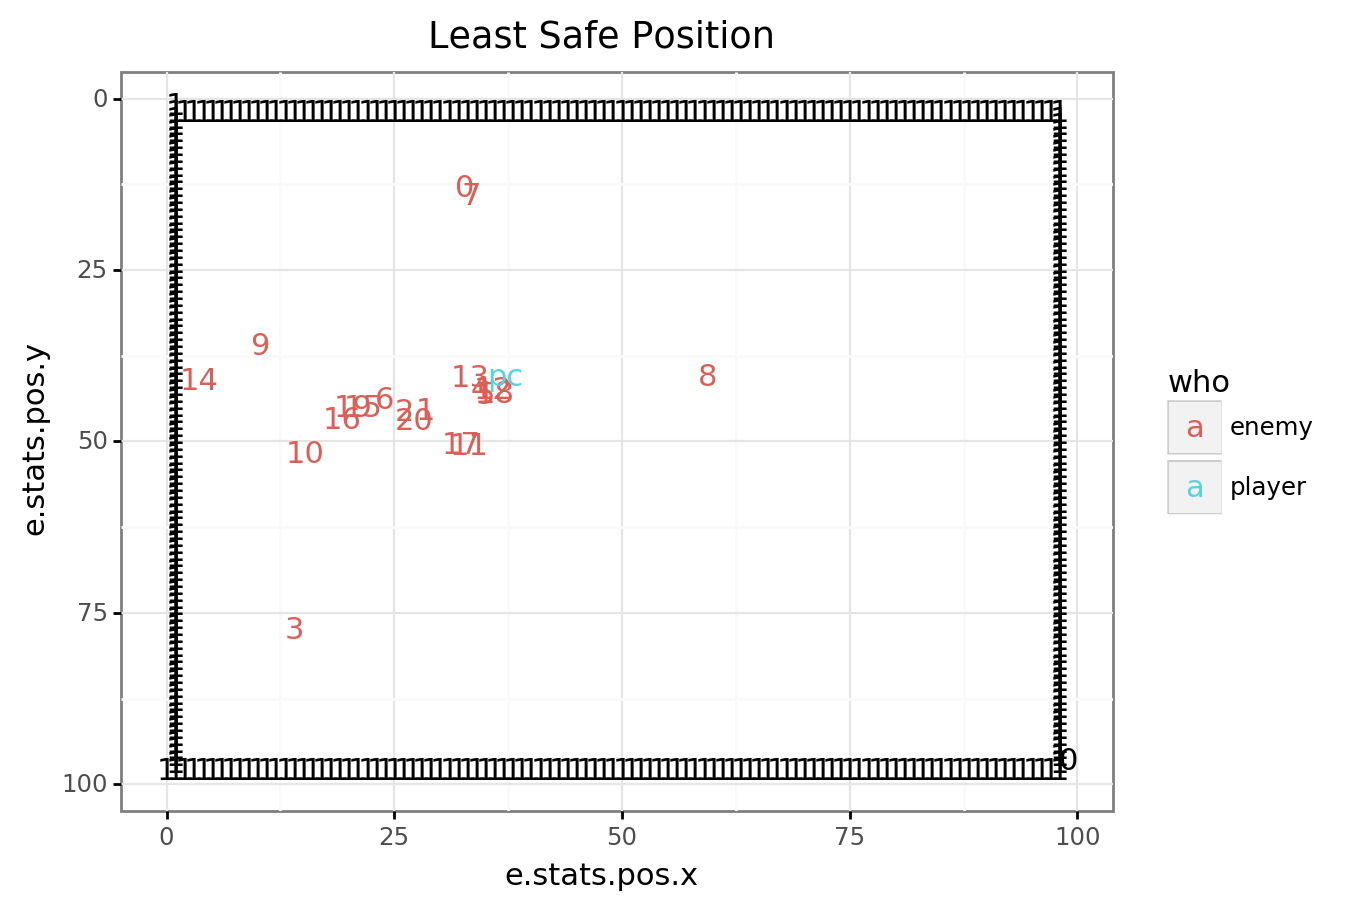

<ggplot: (7569581155)>

In [17]:
display(X.iloc[least_safe_idxs[0],0:8])
display(y.iloc[least_safe_idxs[0],:])
(
    plot_utils.plot_state(game_states[X.index.values[least_safe_idxs[0]][0]],[collision_layer],['black'])
    + ggtitle('Least Safe Position')
)

e.stats.hp       50.000000
e.stats.mp        0.000000
e.stats.pos.x    28.471687
e.stats.pos.y    45.515106
pc.stats.hp      84.000000
pc.stats.mp      12.000000
e.pc.dx           8.830448
e.pc.dy          -5.075050
Name: (13789, 1), dtype: float64

is_entity_alive                        1.0
entity_hp                             50.0
pc_hp                                 84.0
entity_hp_diff                         0.0
pc_hp_diff                             0.0
time_to_entity_hp_diff              2155.0
time_above_median_entity_hp_diff       0.0
time_to_pc_hp_diff                    14.0
time_above_median_pc_hp_diff           0.0
Name: (13789, 1), dtype: float64

/Users/leopekelis/flare/flare-ai/utils/plot_utils.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  }, names=['who']


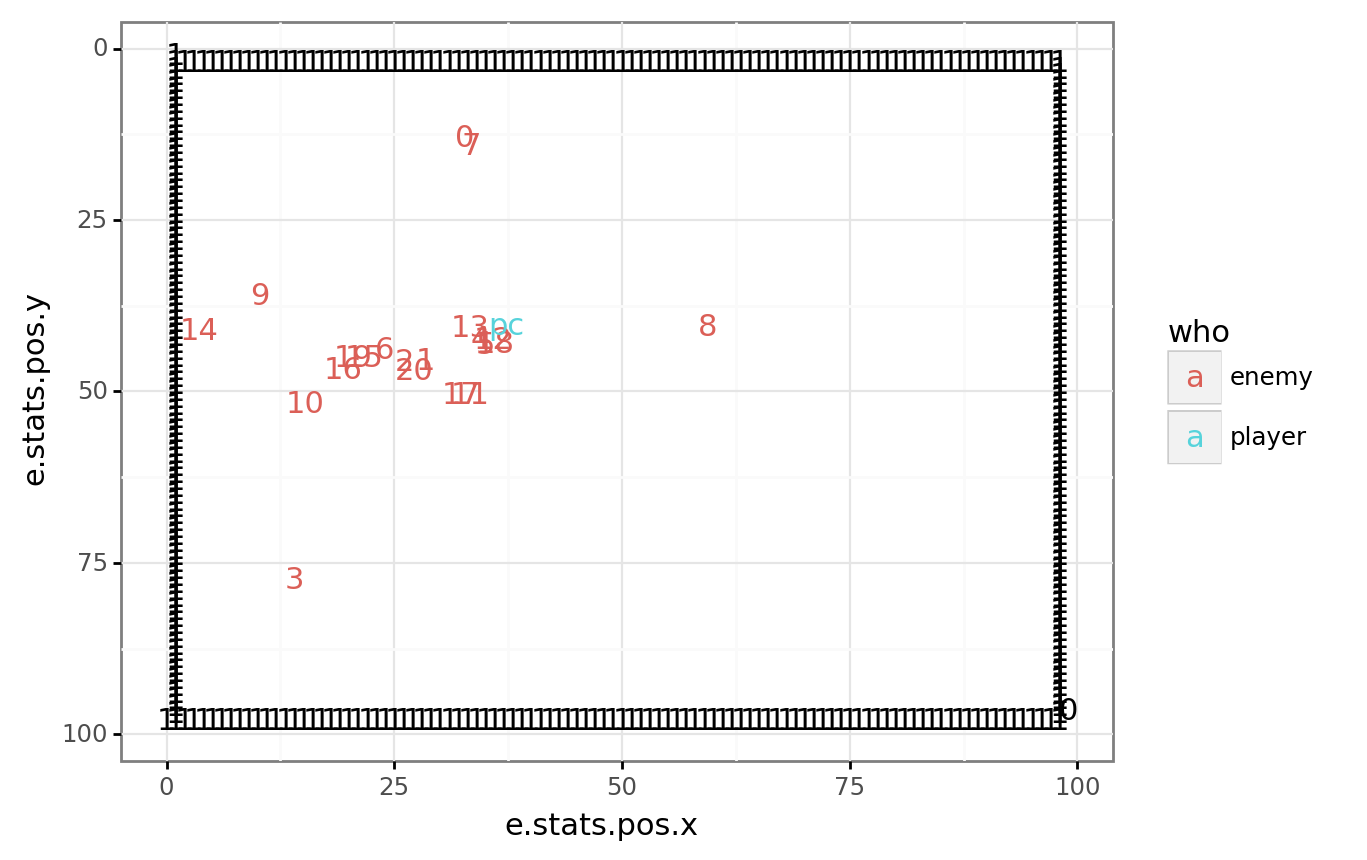

<ggplot: (-9223372029285147504)>

In [18]:
display(X.iloc[least_safe_idxs[1],0:8])
display(y.iloc[least_safe_idxs[1],:])
(
    plot_utils.plot_state(game_states[X.index.values[least_safe_idxs[1]][0]],[collision_layer],['black'])
)

e.stats.hp        50.000000
e.stats.mp         0.000000
e.stats.pos.x     30.226288
e.stats.pos.y     23.290051
pc.stats.hp      100.000000
pc.stats.mp       12.000000
e.pc.dx           50.361664
e.pc.dy           -3.996609
Name: (10883, 2), dtype: float64

is_entity_alive                        1.0
entity_hp                             50.0
pc_hp                                100.0
entity_hp_diff                         0.0
pc_hp_diff                             0.0
time_to_entity_hp_diff              1819.0
time_above_median_entity_hp_diff       0.0
time_to_pc_hp_diff                   515.0
time_above_median_pc_hp_diff           1.0
Name: (10883, 2), dtype: float64

/Users/leopekelis/flare/flare-ai/utils/plot_utils.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  }, names=['who']


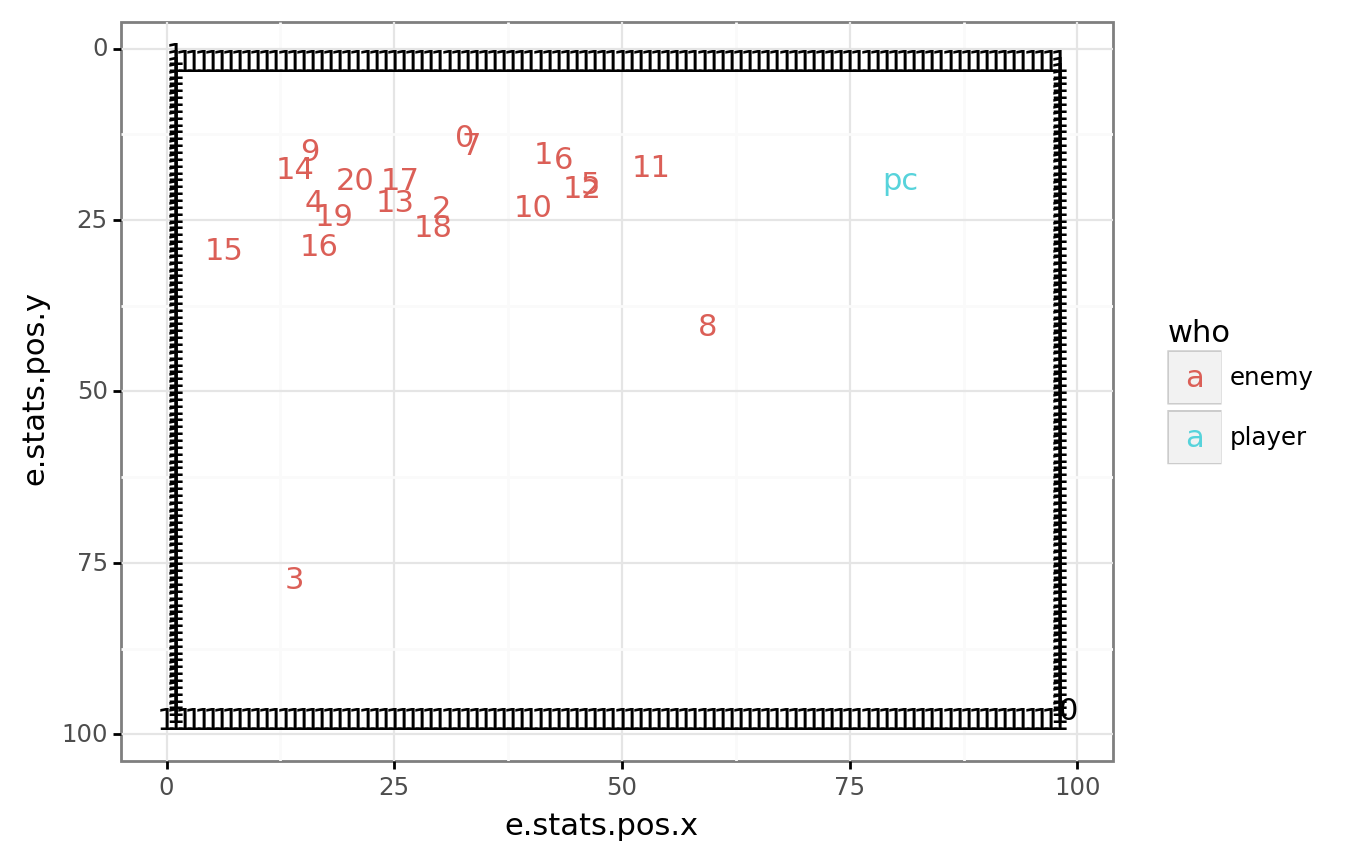

<ggplot: (-9223372029231157991)>

In [19]:
display(X.iloc[least_safe_idxs[2],0:8])
display(y.iloc[least_safe_idxs[2],:])
(
    plot_utils.plot_state(game_states[X.index.values[least_safe_idxs[2]][0]],[collision_layer],['black'])
)

## Most Safe Positions

e.stats.hp       150.000000
e.stats.mp         0.000000
e.stats.pos.x     26.123579
e.stats.pos.y     38.391457
pc.stats.hp       66.000000
pc.stats.mp       12.000000
e.pc.dx           -6.113800
e.pc.dy           -1.948388
Name: (14542, 15), dtype: float64

is_entity_alive                         1.0
entity_hp                             150.0
pc_hp                                  66.0
entity_hp_diff                          0.0
pc_hp_diff                              0.0
time_to_entity_hp_diff              12235.0
time_above_median_entity_hp_diff        1.0
time_to_pc_hp_diff                     14.0
time_above_median_pc_hp_diff            0.0
Name: (14542, 15), dtype: float64

0    1.000000e+00
1    1.138834e-08
Name: 264778, dtype: float32

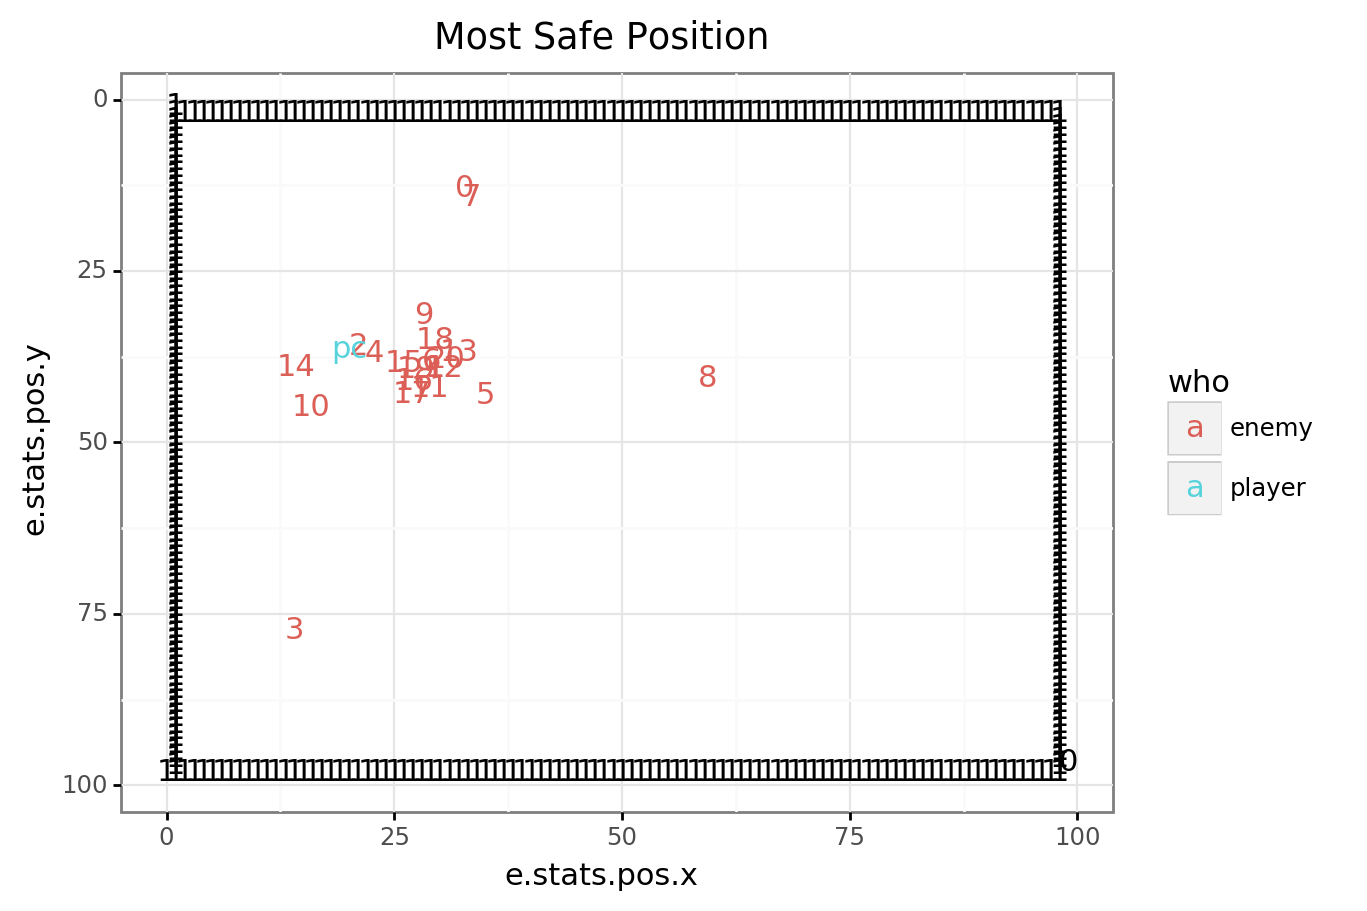

<ggplot: (358110205)>

In [17]:
display(
    X.iloc[safest_idxs[0],0:8], 
    y.iloc[safest_idxs[0],:],
    pred.iloc[safest_idxs[0],:]
)

(
    plot_utils.plot_state(game_states[X.index.values[safest_idxs[0]][0]],[collision_layer],['black'])
    + ggtitle('Most Safe Position')
)

e.stats.hp        50.000000
e.stats.mp         0.000000
e.stats.pos.x     14.596383
e.stats.pos.y     41.651062
pc.stats.hp      100.000000
pc.stats.mp       12.000000
e.pc.dx           -7.606383
e.pc.dy           -7.751060
Name: (9246, 9), dtype: float64

is_entity_alive                        1.0
entity_hp                             50.0
pc_hp                                100.0
entity_hp_diff                         0.0
pc_hp_diff                             0.0
time_to_entity_hp_diff              4952.0
time_above_median_entity_hp_diff       1.0
time_to_pc_hp_diff                   606.0
time_above_median_pc_hp_diff           1.0
Name: (9246, 9), dtype: float64

0    1.000000e+00
1    1.660143e-09
Name: 158264, dtype: float32

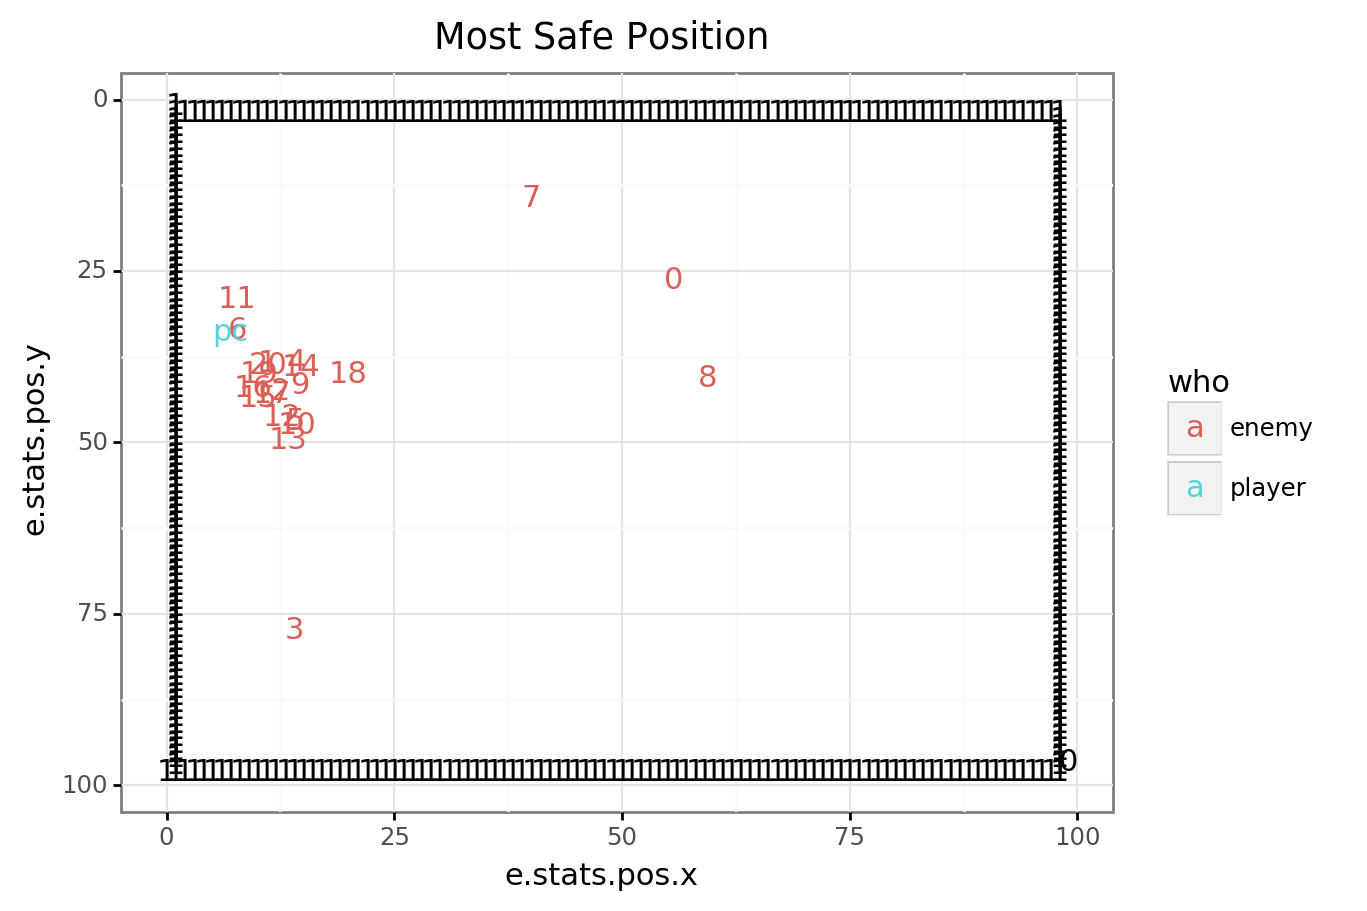

<ggplot: (359983375)>

In [18]:
display(
    X.iloc[safest_idxs[1],0:8], 
    y.iloc[safest_idxs[1],:],
    pred.iloc[safest_idxs[1],:]
)

(
    plot_utils.plot_state(game_states[X.index.values[safest_idxs[1]][0]],[collision_layer],['black'])
    + ggtitle('Most Safe Position')
)

e.stats.hp        50.000000
e.stats.mp         0.000000
e.stats.pos.x     14.334014
e.stats.pos.y     47.399044
pc.stats.hp      100.000000
pc.stats.mp       12.000000
e.pc.dx           -7.344014
e.pc.dy          -13.499042
Name: (9241, 10), dtype: float64

is_entity_alive                        1.0
entity_hp                             50.0
pc_hp                                100.0
entity_hp_diff                         0.0
pc_hp_diff                             0.0
time_to_entity_hp_diff              5056.0
time_above_median_entity_hp_diff       1.0
time_to_pc_hp_diff                   710.0
time_above_median_pc_hp_diff           1.0
Name: (9241, 10), dtype: float64

0    1.000000e+00
1    3.035605e-11
Name: 158160, dtype: float32

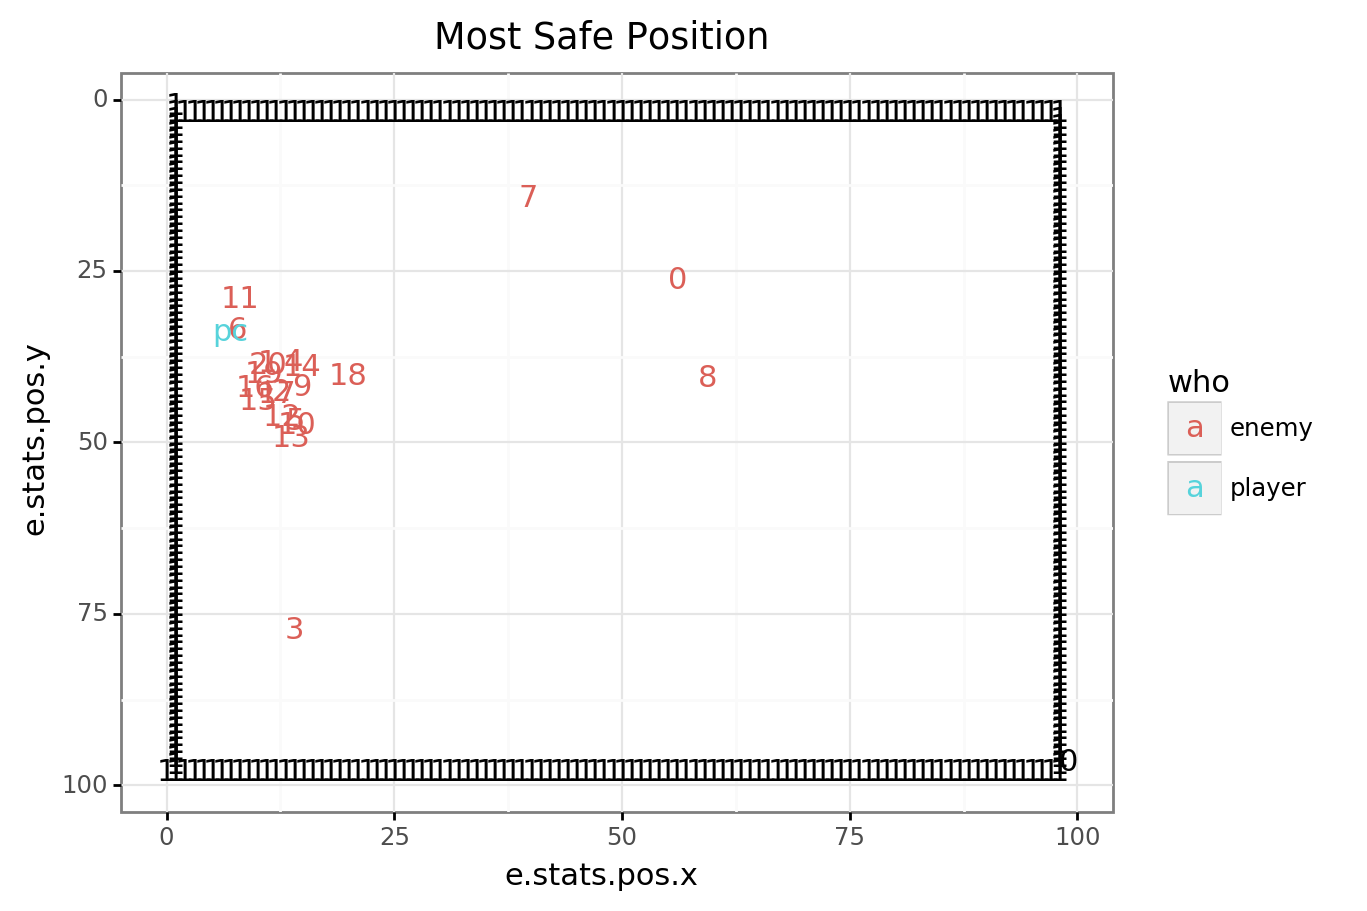

<ggplot: (-9223372036494223293)>

In [19]:
display(
    X.iloc[safest_idxs[2],0:8], 
    y.iloc[safest_idxs[2],:],
    pred.iloc[safest_idxs[2],:]
)

(
    plot_utils.plot_state(game_states[X.index.values[safest_idxs[2]][0]],[collision_layer],['black'])
    + ggtitle('Most Safe Position')
)

# Save model for serving in C

In [20]:
model.session

In [21]:
model.inputs

[<tf.Tensor 'InputData/X:0' shape=(?, 108) dtype=float32>]

In [22]:
model.targets

[<tf.Tensor 'TargetsData/Y:0' shape=(?, 2) dtype=float32>]

In [23]:
signature = tf.saved_model.signature_def_utils.predict_signature_def(                                                                        
    inputs={'game_state': model.inputs[0]}, outputs={'scores': model.targets[0]})

In [24]:
class _DumpableGraph(object):
    """The dumpable graph
        https://github.com/tflearn/tflearn/issues/605
    """
    Keys = [ "summary_tags", tf.GraphKeys.GRAPH_CONFIG, tf.GraphKeys.DATA_PREP, tf.GraphKeys.DATA_AUG, tf.GraphKeys.TRAIN_OPS ] #pylint: disable=I0011,E1101

    def __init__(self):
        """Create a new _DumpableGraph
        """
        self._values = {}

    def __enter__(self):
        """Make this graph dumpable
        """
        for key in self.Keys:
            values = tf.get_collection_ref(key)
            self._values[key] = list(values)
            del values[:]

    def __exit__(self, _, __, ___):
        """Restore this graph
        """
        for key in self.Keys:
            if key not in self._values:
                continue
            tf.get_collection_ref(key).extend(self._values[key])

In [25]:
with _DumpableGraph():
    builder = tf.saved_model.builder.SavedModelBuilder(MODEL_DIR + MODEL_NAME + '_saved_model')                                                                    

    builder.add_meta_graph_and_variables(                                                                                                        
        sess=model.session,                                                                                                                    
        tags=[tf.saved_model.tag_constants.SERVING],                                                                                             
        signature_def_map={                                                                                                                      
            tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:                                                                
                signature                                                                                                                        
        }
    )
    
    builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/Users/lpekelis/flare/flare-ai/models/median_time_to_damage_20180805_094041_saved_model/saved_model.pb'


In [26]:
builder = tf.saved_model.builder.SavedModelBuilder(MODEL_DIR + MODEL_NAME + '_saved_model')                                                                    

builder.add_meta_graph_and_variables(                                                                                                        
    sess=model.session,                                                                                                                    
    tags=[tf.saved_model.tag_constants.SERVING],                                                                                             
    signature_def_map={                                                                                                                      
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:                                                                
            signature                                                                                                                        
    })                                                                                                                                       

builder.save()

AssertionError: Export directory already exists. Please specify a different export directory: /Users/lpekelis/flare/flare-ai/models/median_time_to_damage_20180805_094041_saved_model

## Reload saved_model to make sure it works

In [27]:
with tf.Session(graph=tf.Graph()) as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], MODEL_DIR + MODEL_NAME + '_saved_model')
    display(sess.graph.get_operations())

INFO:tensorflow:Restoring parameters from b'/Users/lpekelis/flare/flare-ai/models/median_time_to_damage_20180805_094041_saved_model/variables/variables'


[<tf.Operation 'is_training/Initializer/Const' type=Const>,
 <tf.Operation 'is_training' type=VariableV2>,
 <tf.Operation 'is_training/Assign' type=Assign>,
 <tf.Operation 'is_training/read' type=Identity>,
 <tf.Operation 'Assign/value' type=Const>,
 <tf.Operation 'Assign' type=Assign>,
 <tf.Operation 'Assign_1/value' type=Const>,
 <tf.Operation 'Assign_1' type=Assign>,
 <tf.Operation 'InputData/X' type=Placeholder>,
 <tf.Operation 'FullyConnected/W/Initializer/truncated_normal/shape' type=Const>,
 <tf.Operation 'FullyConnected/W/Initializer/truncated_normal/mean' type=Const>,
 <tf.Operation 'FullyConnected/W/Initializer/truncated_normal/stddev' type=Const>,
 <tf.Operation 'FullyConnected/W/Initializer/truncated_normal/TruncatedNormal' type=TruncatedNormal>,
 <tf.Operation 'FullyConnected/W/Initializer/truncated_normal/mul' type=Mul>,
 <tf.Operation 'FullyConnected/W/Initializer/truncated_normal' type=Add>,
 <tf.Operation 'FullyConnected/W' type=VariableV2>,
 <tf.Operation 'FullyConnec